In [0]:
%pip install langdetect

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

The dataset was uploaded into Databricks as a Delta table.
Since Delta tables are stored in the Databricks catalog,
we first load the data using Spark.
Spark allows us to efficiently read and inspect the table before processing.

In [0]:
df = spark.table("`workspace`.`default`.`amazon-product-reviews`")
df.show(5)


+----------+--------------------+--------------------+----------------+------------+-------------------+------+------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|product_id|        product_name|            category|discounted_price|actual_price|discount_percentage|rating|rating_count|        about_product|             user_id|           user_name|           review_id|        review_title|      review_content|            img_link|        product_link|
+----------+--------------------+--------------------+----------------+------------+-------------------+------+------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|B07JW9H4J1|Wayona Nylon Brai...|Computers&Accesso...|            ₹399|      ₹1,099|                64%|   4.2|      2

The dataset contains comma-separated fields (user_id, user_name, review_id, review_title, review_content)
that must be split into lists and expanded into individual rows.
These row-wise operations are easier and more reliable in Pandas than in Spark.
Therefore, we convert the Spark DataFrame to a Pandas DataFrame before applying the explode logic.

In [0]:
df_pd = df.toPandas()
df_pd.head()

product_id  ...                                       product_link
0  B07JW9H4J1  ...  https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1  B098NS6PVG  ...  https://www.amazon.in/Ambrane-Unbreakable-Char...
2  B096MSW6CT  ...  https://www.amazon.in/Sounce-iPhone-Charging-C...
3  B08HDJ86NZ  ...  https://www.amazon.in/Deuce-300-Resistant-Tang...
4  B08CF3B7N1  ...  https://www.amazon.in/Portronics-Konnect-POR-1...

[5 rows x 16 columns]

In [0]:
print(type(df_pd))
print(df_pd.columns)
print(df_pd.shape)

<class 'pandas.core.frame.DataFrame'>
Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')
(1465, 16)


STEP 1 — Expand Comma-Separated Review Fields
The original dataset stores multiple reviews inside a single row.
Fields such as user_id, user_name, review_id, review_title, and review_content contain comma-separated values, meaning each row actually represents several reviews.

To prepare the dataset for NLP, sentiment analysis, and recommendation modeling, we convert these comma-separated lists into individual rows.

What we do in this step:

Split each review-related column by commas
Align the length of the lists within each row (using user_id count as the reference)
Trim or pad fields where necessary
Explode the lists so that each row becomes exactly one review
Why this step is necessary:

NLP models require one review per row
Sentiment analysis needs review-level text
Recommendation systems depend on individual user_id → product_id interactions
Synthetic data generation must start from clean, atomic rows
Machine learning methods cannot work with multiple reviews packed into a single row
After exploding, the new dataset df_long contains one row per review and is ready for preprocessing.

In [0]:
import pandas as pd

# We will expand:
# 'user_id', 'user_name', 'review_id', 'review_title', 'review_content'

def split_and_align(row):
    # Convert to string and split on comma
    users   = str(row['user_id']).split(',')
    names   = str(row['user_name']).split(',')
    rids    = str(row['review_id']).split(',')
    titles  = str(row['review_title']).split(',')
    content = str(row['review_content']).split(',')

    # Use user_id count as the "true" number of reviews in this row
    n = len(users)

    def fix_len(lst):
        # If list is longer (because text contains commas), trim it
        if len(lst) >= n:
            return lst[:n]
        # If shorter, pad with empty strings
        return lst + [''] * (n - len(lst))

    users   = fix_len(users)
    names   = fix_len(names)
    rids    = fix_len(rids)
    titles  = fix_len(titles)
    content = fix_len(content)

    return pd.Series({
        'user_id_list': users,
        'user_name_list': names,
        'review_id_list': rids,
        'review_title_list': titles,
        'review_content_list': content
    })

# Apply ON df_pd (PANDAS)
split_cols = df_pd.apply(split_and_align, axis=1)

# Attach the new list columns
df_expanded = pd.concat([df_pd, split_cols], axis=1)

# Drop original combined columns and explode into one row per review
df_long = (
    df_expanded
        .drop(columns=['user_id', 'user_name', 'review_id', 'review_title', 'review_content'])
        .rename(columns={
            'user_id_list': 'user_id',
            'user_name_list': 'user_name',
            'review_id_list': 'review_id',
            'review_title_list': 'review_title',
            'review_content_list': 'review_content'
        })
        .explode(['user_id', 'user_name', 'review_id', 'review_title', 'review_content'],
                 ignore_index=True)
)

print("Original shape:", df_pd.shape)
print("After explode shape:", df_long.shape)
df_long[['product_id', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content']].head()


Original shape: (1465, 16)
After explode shape: (11503, 16)


product_id  ...                                     review_content
0  B07JW9H4J1  ...     Looks durable Charging is fine tooNo complains
1  B07JW9H4J1  ...                            Charging is really fast
2  B07JW9H4J1  ...                                      good product.
3  B07JW9H4J1  ...               Till now satisfied with the quality.
4  B07JW9H4J1  ...  This is a good product . The charging speed is...

[5 rows x 6 columns]

STEP — Clean Currency Columns (discounted_price & actual_price)
The dataset contains price fields such as discounted_price and actual_price, but their values include formatting characters like the rupee symbol (₹ or â‚¹), commas, or dashes. These cannot be used directly for numerical analysis or modeling.

To prepare these fields:

We remove currency symbols (₹, â‚¹)
Remove commas from values such as "1,299"
Strip whitespace and handle empty or placeholder values such as "-"
Convert the cleaned string safely into a floating-point number
Replace invalid or unconvertible values with NaN
After applying this cleaning function, both price columns become clean numeric fields that can be used for statistical analysis, feature engineering, and modeling.

In [0]:
import numpy as np
import pandas as pd

# Function to clean currency values
def clean_price(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    
    # Remove rupee symbols and encoding artifacts
    s = s.replace("₹", "").replace("â‚¹", "")
    
    # Remove commas and strip whitespace
    s = s.replace(",", "").strip()
    
    # Handle empty or placeholder values
    if s == "" or s == "-":
        return np.nan
    
    # Convert to float safely
    try:
        return float(s)
    except:
        return np.nan

# Apply the cleaning function to both price columns
price_cols = ['discounted_price', 'actual_price']

for col in price_cols:
    if col in df_long.columns:
        df_long[col] = df_long[col].apply(clean_price)

# Display cleaned price columns
df_long[price_cols].head()


discounted_price  actual_price
0             399.0        1099.0
1             399.0        1099.0
2             399.0        1099.0
3             399.0        1099.0
4             399.0        1099.0

STEP — Clean Rating Count and Discount Percentage
The fields rating_count and discount_percentage contain characters that make them unusable for numerical analysis in their raw form.

rating_count values such as "24,269" include commas, so we remove commas and convert the result into an integer.
discount_percentage values such as "64%" include the percent sign, so we remove % and convert the result to a numeric (float) value.
Both conversions ensure that these fields become clean numerical features suitable for descriptive statistics, visualizations, and machine learning models.

In [0]:
# Clean rating_count: "24,269" → 24269
if 'rating_count' in df_long.columns:

    def clean_int(x):
        if pd.isna(x):
            return np.nan
        s = str(x).replace(",", "").strip()  # remove commas
        return int(s) if s.isdigit() else np.nan

    df_long['rating_count'] = df_long['rating_count'].apply(clean_int)


# Clean discount_percentage: "64%" → 64.0
if 'discount_percentage' in df_long.columns:

    def clean_percent(x):
        if pd.isna(x):
            return np.nan
        s = str(x).replace("%", "").strip()  # remove %
        try:
            return float(s)
        except:
            return np.nan

    df_long['discount_percentage'] = df_long['discount_percentage'].apply(clean_percent)


# Show cleaned columns
df_long[['discounted_price', 'actual_price', 'rating_count', 'discount_percentage']].head()

discounted_price  actual_price  rating_count  discount_percentage
0             399.0        1099.0       24269.0                 64.0
1             399.0        1099.0       24269.0                 64.0
2             399.0        1099.0       24269.0                 64.0
3             399.0        1099.0       24269.0                 64.0
4             399.0        1099.0       24269.0                 64.0

STEP — Remove Non-Essential Product Metadata Columns
The dataset contains additional product-related fields such as:

product_name
category
about_product
img_link
product_link
These columns are descriptive attributes of the product and are not required for the review-level NLP workflow (text cleaning, sentiment modeling, synthetic data generation, or user–item modeling).

To simplify the dataset and reduce memory usage, we drop these non-essential columns and keep only the fields necessary for text processing and feature engineering.

After this step, df_long contains a cleaner structure with only review-related information.


In [0]:
# Columns to drop
cols_to_drop = ['product_name', 'category', 'about_product', 'img_link', 'product_link']

# Keep only the ones that actually exist to avoid errors
cols_to_drop = [c for c in cols_to_drop if c in df_long.columns]

# Drop the columns
df_long = df_long.drop(columns=cols_to_drop)

df_long.head()

product_id  ...                                     review_content
0  B07JW9H4J1  ...     Looks durable Charging is fine tooNo complains
1  B07JW9H4J1  ...                            Charging is really fast
2  B07JW9H4J1  ...                                      good product.
3  B07JW9H4J1  ...               Till now satisfied with the quality.
4  B07JW9H4J1  ...  This is a good product . The charging speed is...

[5 rows x 11 columns]

STEP — Detect and Remove Duplicate Reviews
To ensure data quality and prevent repeated reviews from affecting analysis or modeling, we identify and remove duplicate records based on a strict review identifier key.

For Amazon-style datasets, the combination of:

product_id
user_id
review_id
uniquely identifies a single user review for a specific product.

If this combination appears more than once, it represents a true duplicate entry. In this step, we:

Search for all duplicate rows based on the strict key
Display the duplicated entries for verification
Remove duplicates while keeping only the first occurrence
Check the final dataset shape after cleanup
This ensures that only clean, unique review records are used in the subsequent preprocessing and modeling stages.

In [0]:
 #STRICT duplicate key
dup_key = ['product_id', 'user_id', 'review_id']

# 1️⃣ Find duplicate rows (but keep ALL copies for inspection)
duplicates_df = df_long[df_long.duplicated(subset=dup_key, keep=False)]

print("Number of duplicate rows:", duplicates_df.shape[0])
display(duplicates_df)   # Shows all duplicates
# 2️⃣ Remove duplicates (keep only the first occurrence)
df_long = df_long.drop_duplicates(subset=dup_key, keep='first')

print("Shape after removing duplicates:", df_long.shape)

Number of duplicate rows: 1620


product_id discounted_price actual_price discount_percentage rating rating_count user_id user_name review_id review_title review_content B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AG3D6O4STAQKAY2UVGEUV46KN35Q Manav R3HXWT0LRP0NMF Satisfied Looks durable Charging is fine tooNo complains B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AHMY5CWJMMK5BJRBBSNLYT3ONILA Adarsh gupta R2AJM3LFTLZHFO Charging is really fast Charging is really fast B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AHCTC6ULH4XB6YHDY6PCH2R772LQ Sundeep R6AQJGUP6P86 Value for money good product. B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AGYHHIERNXKA6P5T7CZLXKVPT7IQ S.Sayeed Ahmed R1KD19VHEDV0OR Product review Till now satisfied with the quality. B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q jaspreet singh R3C02RMYQMK6FC Good quality This is a good product . The charging speed is slower than the original iPhone cable B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AENGU523SXMOS7JPDTW52PNNVWGQ Khaja moin R39GQRVBUZBWGY Good product Good quality B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AEQJHCVTNINBS4FKTBGQRQTGTE5Q Anand R2K9EDOE15QIRJ Good Product would recommend B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AFC3FFC5PKFF5PMA52S3VCHOZ5FQ S.ARUMUGAM R3OI7YT648TL8I As of now seems good https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/81---F1ZgHL._SY88.jpg B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AECPFYFQVRUWC3KGNLJIOREFP5LQ ArdKn RGIQEG07R9HS2 A Good Braided Cable for Your Type C Device I ordered this cable to connect my phone to Android Auto of car. The cable is really strong and the connection ports are really well made. I already has a Micro USB cable from Ambrane and it's still in good shape. I connected my phone to the car using the cable and it got connected well and no issues. I also connected it to the charging port and yes it has Fast Charging support. B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AGYYVPDD7YG7FYNBXNGXZJT525AQ Nirbhay kumar R1SMWZQ86XIN8U Good quality product from ambrane It quality is good at this price and the main thing is that i didn't ever thought that this cable will be so long it's good one and charging power is too good and also supports fast charging B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AHONIZU3ICIEHQIGQ6R2VFRSBXOQ Sagar Viswanathan R2J3Y1WL29GWDE Super cable Value for money B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AFPHD2CRPDZMWMBL7WXRSVYWS5JA Asp RYGGS0M09S3KY As with extra length👍 B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AEZ346GX3HJ4O4XNRPHCNHXQURMQ Placeholder R17KQRUTAN5DKS Good quality Good B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AEPSWFPNECKO34PUC7I56ITGXR6Q BharanI R3AAQGS6HP2QUK Good product working fine B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AHWVEHR5DYLVFTO2KF3IZATFQSWQ sonia R1HDNOG6TO2CCA its good Product quality is good B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AH4QT33M55677I7ISQOAKEQWACYQ Niam R3PHKXYA5AFEOU Good quality for the price but one issue with my unit Good B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA Kunal R3J3EQQ9TZI5ZJ Good speed for earlier versions Not quite durable and sturdy B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AESFLDV2PT363T2AQLWQOWZ4N3OA Himanshu R3E7WBGK7ID0KV Good Product https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/71rIggrbUCL._SY88.jpg B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AHTPQRIMGUD4BYR5YIHBH3CCGEFQ viswanath RWU79XKQ6I1QF Working good Working good B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AEUVWXYP5LT7PZLLZENEO2NODPBQ sai niharka R25X4TBMPY91LX Good for the price https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/61bKp9YO6wL._SY88.jpg B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AHC7MPW55DOO6WNCOQVA2VHOD26A saqib malik R27OK7G99VK0TR Good Product B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AFDI6FRPFBTNBG7BAEB7JDJSMKDQ Aashiq R207CYDCHJJTCJ Worth for money Very nice product B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AFQKCEEEKXCOHTDG4WUN3XPPHJQQ Ramu Challa R3PCU8XMU173BT Working nice Working well B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AHKUUFNMBZIDLSSPA4FEHIO2EC

Shape after removing duplicates: (10605, 11)


In [0]:
df_long.duplicated(subset=dup_key).sum()

np.int64(0)

STEP — Missing Values Analysis and Removal
To ensure data quality before preprocessing and modeling, we first inspect the dataset for missing values. This includes:

Counting the number of missing values in each column
Calculating the percentage of missing data
Displaying a summary table for easy interpretation
Once missing values are identified, we remove all rows containing any missing entries. This is appropriate because our dataset represents user reviews, where each record must include complete information (product ID, user ID, review ID, review text, rating, etc.). Incomplete entries may introduce bias or errors in downstream NLP tasks.

After dropping missing rows, we verify that all remaining fields contain no null values, ensuring a clean and reliable dataset for the next steps of the pipeline.

In [0]:
# Check total missing values per column
missing_values = df_long.isna().sum()

print("Missing values per column:")
print(missing_values)

# Optional: show percentage of missing values
missing_percentage = (df_long.isna().mean() * 100).round(2)

print("\nPercentage of missing values per column:")
print(missing_percentage)

# Display as a table (Databricks nice display)
display(pd.DataFrame({
    "missing_count": missing_values,
    "missing_percentage": missing_percentage
}))
df_long_clean = df_long.dropna()

print("\nShape before removing missing values:", df_long.shape)
print("Shape after removing missing values:", df_long_clean.shape)

# 3️⃣ Verify missing values have been removed
print("\nRemaining missing values (should all be 0):")
print(df_long_clean.isna().sum())

Missing values per column:
product_id             0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
dtype: int64

Percentage of missing values per column:
product_id             0.00
discounted_price       0.00
actual_price           0.00
discount_percentage    0.00
rating                 0.00
rating_count           0.02
user_id                0.00
user_name              0.00
review_id              0.00
review_title           0.00
review_content         0.00
dtype: float64


missing_count missing_percentage 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 2 0.02 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0


Shape before removing missing values: (10605, 11)
Shape after removing missing values: (10603, 11)

Remaining missing values (should all be 0):
product_id             0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
dtype: int64


In [0]:
df_long_clean = df_long.dropna()

In [0]:
# Check total missing values per column
missing_values = df_long.isna().sum()

print("Missing values per column:")
print(missing_values)

Missing values per column:
product_id             0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
dtype: int64


In [0]:
# Check data types
df_long.dtypes



product_id              object
discounted_price       float64
actual_price           float64
discount_percentage    float64
rating                 float64
rating_count           float64
user_id                 object
user_name               object
review_id               object
review_title            object
review_content          object
dtype: object

In [0]:
import pandas as pd

# Convert 'rating' to numeric
df_long['rating'] = pd.to_numeric(df_long['rating'], errors='coerce')

# Optional: check the result
print(df_long['rating'].head())
print(df_long['rating'].dtype)


0    4.2
1    4.2
2    4.2
3    4.2
4    4.2
Name: rating, dtype: float64
float64


STEP — Replace Image/URL-Based Review Content
After cleaning and removing missing values, our working dataset is stored in df_long_clean. We continue preprocessing using this cleaned dataset.

Some rows in the review_content column contain URLs, image references, or other non-text content instead of actual review text. Examples include:

Links to Amazon products
Image URLs (.jpg, .png, etc.)
Placeholder text like “see image”
Very short or empty content
These entries are not useful for NLP and sentiment analysis.

To address this, we replace any review_content that contains a URL, image reference, or empty text with the corresponding review_title. This ensures each review contains meaningful text before moving into NLP preprocessing.

A regular expression is used to detect URLs and image patterns, and the replacement is applied row-by-row.

In [0]:
import pandas as pd
import re

# Work with the cleaned dataset
df_long = df_long_clean.copy()

def replace_links_with_title(row):
    content = str(row['review_content']).strip()
    title = str(row['review_title']).strip()
    
    # Pattern: detect URLs or image references
    url_pattern = r'(http\S+|www\.\S+|\.jpg|\.png|\.jpeg|image|imgur|amazon\.\S+)'
    
    # Replace content if URL-like or empty
    if re.search(url_pattern, content.lower()) or content in ["", " ", "nan"]:
        return title
    
    return content

# Apply replacement
df_long['review_content'] = df_long.apply(replace_links_with_title, axis=1)

df_long[['review_title', 'review_content']].head(10)

review_title                                     review_content
0                                    Satisfied     Looks durable Charging is fine tooNo complains
1                      Charging is really fast                            Charging is really fast
2                              Value for money                                      good product.
3                               Product review               Till now satisfied with the quality.
4                                 Good quality  This is a good product . The charging speed is...
5                                 Good product                                       Good quality
6                                 Good Product                                    would recommend
7                         As of now seems good                               As of now seems good
8  A Good Braided Cable for Your Type C Device  I ordered this cable to connect my phone to An...
9            Good quality product from ambrane  It quality is good at this price and the main ...

Language Detection and Filtering of Review Content

This code cell performs automatic language detection on the review_content column to ensure that only English-language reviews are retained for analysis. The steps performed are:

Import required libraries

langdetect for language detection

pandas for dataframe operations

A deterministic seed is set to make detection results reproducible.

Prepare dataset

A copy of the working dataframe (df_long) is created to avoid modifying the original data directly.

Define a language-detection function

Handles empty strings, NaN values, and detection failures by assigning the label "unknown".

Detect the language of each review

Applies the function to review_content and stores the language code in a new column named language.

Inspect language distribution

Prints the value counts of detected languages.

Filter reviews

Keeps only rows where the detected language is English ('en').

Drops the temporary language column after filtering.

Updates df_long to the English-only version.

Display sample records

Shows the first few cleaned, English-only rows.

This ensures that the dataset used for further analysis or model training contains only English review text, improving consistency and reducing noise in downstream tasks such as text classification, sentiment analysis, or synthetic data generation.

In [0]:
from langdetect import detect, DetectorFactory
import pandas as pd

# Ensure deterministic language detection
DetectorFactory.seed = 0

# Work on a copy of your final dataset
df_lang = df_long.copy()

def detect_language(text):
    text = str(text).strip()
    if text == "" or text.lower() == "nan":
        return "unknown"
    try:
        return detect(text)
    except:
        return "unknown"

# Create a language column based on review_content
df_lang['language'] = df_lang['review_content'].apply(detect_language)

# See what languages you have
print("Language counts:")
print(df_lang['language'].value_counts())

# Keep only English reviews
df_lang_en = df_lang[df_lang['language'] == 'en'].copy()

print("\nShape before removing non-English:",df_long.shape)
print("Shape after keeping only English (language == 'en'):", df_lang_en.shape)

# Drop the helper column if you don't need it anymore
df_lang_en = df_lang_en.drop(columns=['language'])

# This is now your new working dataset
df_long = df_lang_en

df_long.head()


Language counts:
language
en         8856
so          321
ro          248
af          200
ca          143
et           77
no           67
fr           63
id           61
de           49
da           48
tl           46
cy           42
nl           37
it           36
unknown      32
hi           28
cs           28
sw           25
vi           22
pl           18
es           17
tr           16
sl           15
sv           15
pt           15
fi           14
hr           14
sq           12
sk           11
hu            8
bn            4
lt            4
te            3
ta            3
ne            2
mr            2
kn            1
Name: count, dtype: int64

Shape before removing non-English: (10603, 11)
Shape after keeping only English (language == 'en'): (8856, 12)


product_id  ...                                     review_content
0  B07JW9H4J1  ...     Looks durable Charging is fine tooNo complains
1  B07JW9H4J1  ...                            Charging is really fast
2  B07JW9H4J1  ...                                      good product.
3  B07JW9H4J1  ...               Till now satisfied with the quality.
4  B07JW9H4J1  ...  This is a good product . The charging speed is...

[5 rows x 11 columns]

In [0]:
df_long['rating'] = pd.to_numeric(df_long['rating'], errors='coerce')
print(df_long['rating'].dtype)


float64


In [0]:
non_numeric = df_long['rating'][pd.to_numeric(df_long['rating'], errors='coerce').isna()]

print(non_numeric)


10053   NaN
10054   NaN
10055   NaN
10057   NaN
10058   NaN
10059   NaN
10060   NaN
Name: rating, dtype: float64


In [0]:
df_long = df_long[pd.to_numeric(df_long['rating'], errors='coerce').notna()]



In [0]:
# Basic overview
df_long.info()

# Number of rows & columns
print("Shape:", df_long.shape)
# Preview
df_long.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8849 entries, 0 to 11502
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           8849 non-null   object 
 1   discounted_price     8849 non-null   float64
 2   actual_price         8849 non-null   float64
 3   discount_percentage  8849 non-null   float64
 4   rating               8849 non-null   float64
 5   rating_count         8849 non-null   float64
 6   user_id              8849 non-null   object 
 7   user_name            8849 non-null   object 
 8   review_id            8849 non-null   object 
 9   review_title         8849 non-null   object 
 10  review_content       8849 non-null   object 
dtypes: float64(5), object(6)
memory usage: 829.6+ KB
Shape: (8849, 11)


product_id  ...                                     review_content
0  B07JW9H4J1  ...     Looks durable Charging is fine tooNo complains
1  B07JW9H4J1  ...                            Charging is really fast
2  B07JW9H4J1  ...                                      good product.
3  B07JW9H4J1  ...               Till now satisfied with the quality.
4  B07JW9H4J1  ...  This is a good product . The charging speed is...

[5 rows x 11 columns]

In [0]:
missing_count = df_long.isna().sum()
print("Missing values per column:")
print(missing_count)


Missing values per column:
product_id             0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
dtype: int64


In [0]:
# Drop rows where any column is null
df_clean = df_long.dropna()

# Check the shape before and after
print("Before:", df_long.shape)
print("After:", df_clean.shape)


Before: (8849, 11)
After: (8849, 11)


%md
## Exploratory Data Analysis (EDA)

This section explores the structure, distribution, and patterns in the cleaned
Amazon review dataset. EDA helps us understand trends, detect anomalies, and
prepare for downstream modeling.

### 1. Dataset Overview
We inspect the size, column types, and sample rows to understand the dataset’s
basic structure.

### 2. Summary Statistics
Descriptive statistics highlight central tendency and variance for numeric fields
such as actual price, discounted price, rating, rating count, and discount
percentage.

### 3. Rating Distribution
The star rating distribution reveals whether the dataset is balanced or skewed
toward certain rating values.

### 4. Discount & Price Patterns
Visualizing discount percentage and price helps understand customer purchasing
behavior and product pricing strategies.

### 5. Review Length Analysis
Review length (word count) helps us understand the nature of customer reviews—
whether they are typically short, long, detailed, or sparse.

### 6. Rating vs Review Length
A boxplot is used to see whether longer reviews correlate with higher or lower
ratings.

This EDA provides a strong foundation for the next stage: **text preprocessing
and sentiment modeling**.



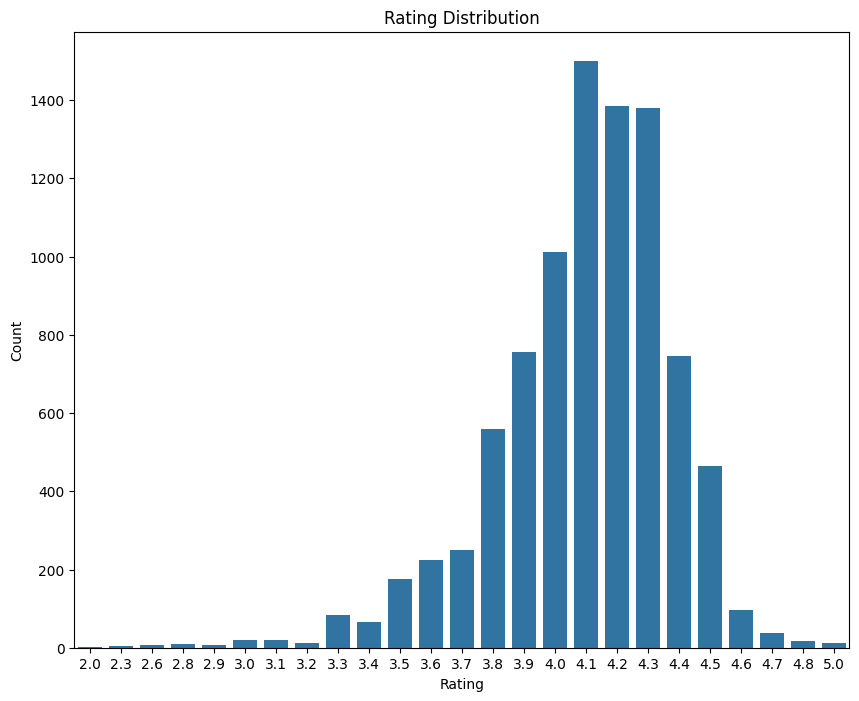

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.countplot(x=df_clean['rating'])
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

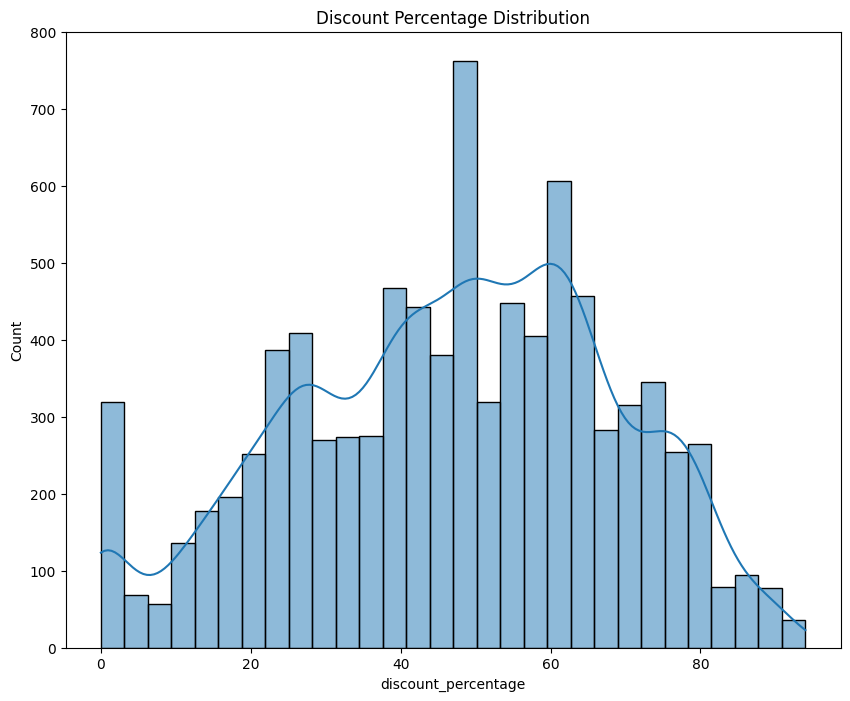

In [0]:
plt.figure(figsize=(10,8))
sns.histplot(df_clean['discount_percentage'], kde=True, bins=30)
plt.title("Discount Percentage Distribution")
plt.show()

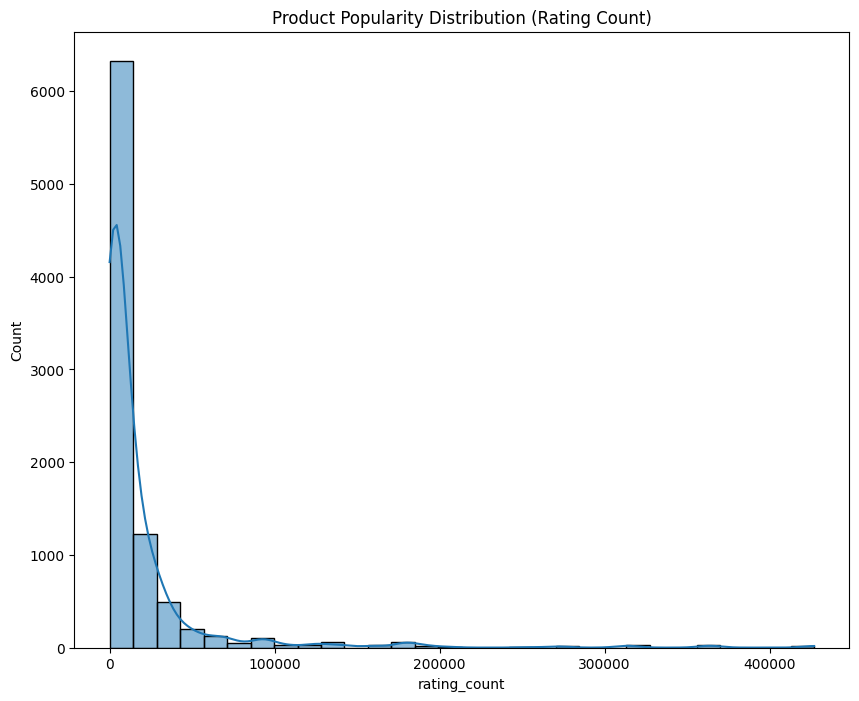

In [0]:
plt.figure(figsize=(10,8))
sns.histplot(df_clean['rating_count'], bins=30, kde=True)
plt.title("Product Popularity Distribution (Rating Count)")
plt.show()

/home/spark-dfda3243-1fcd-4475-9a07-1e/.ipykernel/14129/command-6584007461137058-2607014836:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['review_length'] = df_clean['review_content'].apply(lambda x: len(str(x).split()))


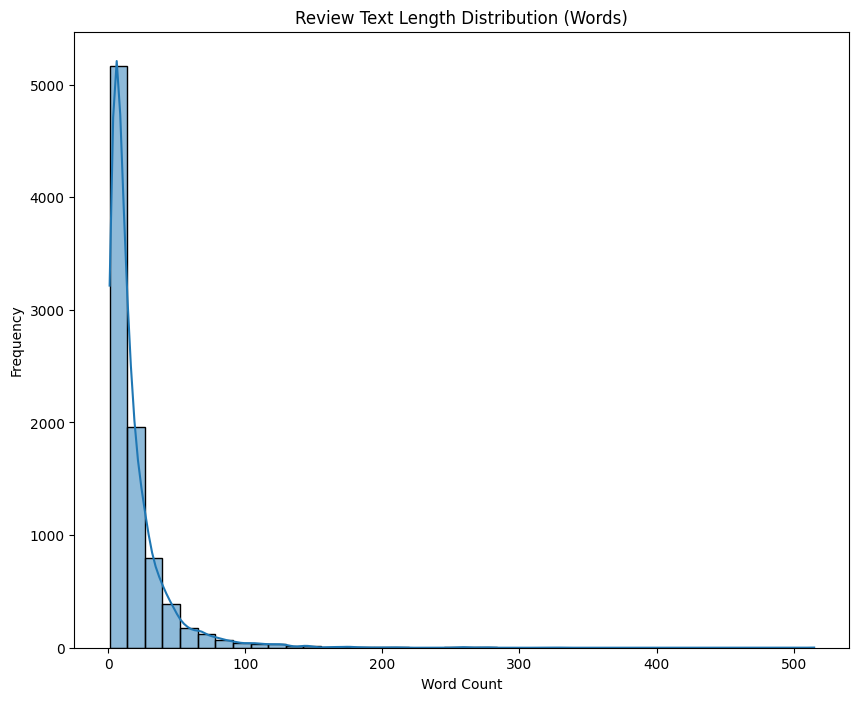

count    8849.000000
mean       18.111877
std        23.201188
min         1.000000
25%         5.000000
50%        11.000000
75%        22.000000
max       515.000000
Name: review_length, dtype: float64

In [0]:
df_clean['review_length'] = df_clean['review_content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,8))
sns.histplot(df_clean['review_length'], bins=40, kde=True)
plt.title("Review Text Length Distribution (Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

df_clean['review_length'].describe()


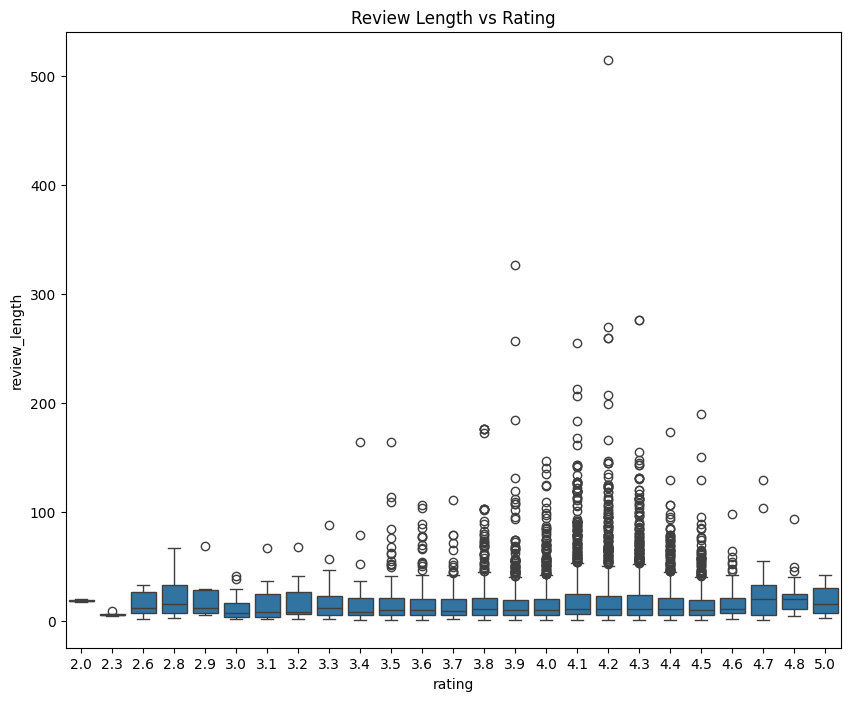

In [0]:
plt.figure(figsize=(10,8))
sns.boxplot(x='rating', y='review_length', data=df_clean)
plt.title("Review Length vs Rating")
plt.show()

In [0]:
df_clean['rating'].unique()

array([4.2, 4. , 3.9, 4.1, 4.3, 4.4, 4.5, 3.7, 3.3, 3.6, 3.4, 3.8, 3.5,
       4.6, 3.2, 5. , 4.7, 3. , 2.8, 3.1, 4.8, 2.3, 2. , 2.6, 2.9])

In [0]:
# Convert the final english-only dataframe to Spark
df_clean_spark = spark.createDataFrame(df_clean)

# Display the table for download
display(df_clean_spark)


product_id discounted_price actual_price discount_percentage rating rating_count user_id user_name review_id review_title review_content B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AG3D6O4STAQKAY2UVGEUV46KN35Q Manav R3HXWT0LRP0NMF Satisfied Looks durable Charging is fine tooNo complains B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AHMY5CWJMMK5BJRBBSNLYT3ONILA Adarsh gupta R2AJM3LFTLZHFO Charging is really fast Charging is really fast B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AHCTC6ULH4XB6YHDY6PCH2R772LQ Sundeep R6AQJGUP6P86 Value for money good product. B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AGYHHIERNXKA6P5T7CZLXKVPT7IQ S.Sayeed Ahmed R1KD19VHEDV0OR Product review Till now satisfied with the quality. B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q jaspreet singh R3C02RMYQMK6FC Good quality This is a good product . The charging speed is slower than the original iPhone cable B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AENGU523SXMOS7JPDTW52PNNVWGQ Khaja moin R39GQRVBUZBWGY Good product Good quality B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AEQJHCVTNINBS4FKTBGQRQTGTE5Q Anand R2K9EDOE15QIRJ Good Product would recommend B07JW9H4J1 399.0 1099.0 64.0 4.2 24269.0 AFC3FFC5PKFF5PMA52S3VCHOZ5FQ S.ARUMUGAM R3OI7YT648TL8I As of now seems good As of now seems good B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AECPFYFQVRUWC3KGNLJIOREFP5LQ ArdKn RGIQEG07R9HS2 A Good Braided Cable for Your Type C Device I ordered this cable to connect my phone to Android Auto of car. The cable is really strong and the connection ports are really well made. I already has a Micro USB cable from Ambrane and it's still in good shape. I connected my phone to the car using the cable and it got connected well and no issues. I also connected it to the charging port and yes it has Fast Charging support. B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AGYYVPDD7YG7FYNBXNGXZJT525AQ Nirbhay kumar R1SMWZQ86XIN8U Good quality product from ambrane It quality is good at this price and the main thing is that i didn't ever thought that this cable will be so long it's good one and charging power is too good and also supports fast charging B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AFPHD2CRPDZMWMBL7WXRSVYWS5JA Asp RYGGS0M09S3KY As with extra length👍 B098NS6PVG 199.0 349.0 43.0 4.0 43994.0 AHWVEHR5DYLVFTO2KF3IZATFQSWQ sonia R1HDNOG6TO2CCA its good Product quality is good B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AESFLDV2PT363T2AQLWQOWZ4N3OA Himanshu R3E7WBGK7ID0KV Good Product Good Product B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AEUVWXYP5LT7PZLLZENEO2NODPBQ sai niharka R25X4TBMPY91LX Good for the price Good for the price B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AHC7MPW55DOO6WNCOQVA2VHOD26A saqib malik R27OK7G99VK0TR Good Product B096MSW6CT 199.0 1899.0 90.0 3.9 7928.0 AHKUUFNMBZIDLSSPA4FEHIO2EC7Q Sanjay gupta R1IMONDOWRNU5V it's a really nice product It's a really nice product B08HDJ86NZ 329.0 699.0 53.0 4.2 94363.0 AEWAZDZZJLQUYVOVGBEUKSLXHQ5A Omkar dhale R3EEUZKKK9J36I Good product Good product B08HDJ86NZ 329.0 699.0 53.0 4.2 94363.0 AH725ST5NW2Y4JZPKUNTIJCUK2BA HEMALATHA REDECAZ7AMPQC Nice Charges good B08HDJ86NZ 329.0 699.0 53.0 4.2 94363.0 AGWIGDEMFIIUAOXYY2QATNBSUGHA amar singh chouhan R2DMKIBGFKBD6R Very first time change I bought this cable for Rs.339 worthy product for this price B08HDJ86NZ 329.0 699.0 53.0 4.2 94363.0 AFSTSLQUV4EVEXWKBOLEFHL2H5YQ Ravi Siddan RC89B5IAJUTR5 Good i tested it in various charger adapters 33w and 18w it supports fast charging as well. B08CF3B7N1 154.0 399.0 61.0 4.2 16905.0 AE3Q6KSUK5P75D5HFYHCRAOLODSA rahuls6099 R1BP4L2HH9TFUP As good as original Bought this instead of original apple B08CF3B7N1 154.0 399.0 61.0 4.2 16905.0 AFUGIFH5ZAFXRDSZHM4QB2KPKFUQ Swasat Borah R16PVJEXKV6QZS Decent does the work for 150rs B08CF3B7N1 154.0 399.0 61.0 4.2 16905.0 AFK4NJOLFSJGWLOJIUIAROJF6YVA Ajay Wadke R2UPDB81N66T4P Good one for secondary use not as fast as apple charger but its a good option if you want cheap and good product B08CF3B7N1 154.0 399.0 61.0 4.2 16905.0